## Defining Variables

In [27]:
num_sites = 18
E_mod = 180 #Brotosudarmo Pg 5
ϕ = 2*π/num_sites

# site_energies
B820_α_β =  [12640,12400]
B850_α_β = [12300,12060] # both from Brotosudarmo pa#averageAbsorptionStrengthpers.
B820_α_β = B850_α_β # for HL all site energy are same, and = B850 ebergies
inter_NC = 226
intra_NC = 254
second_NC_α =-35
second_NC_β = -26
;

In [28]:
using LinearAlgebra
using Distributions
using PyPlot
using StatsBase
using PyCall

function wavenumber_to_nm(wavenumber)
    return 1.0e7 / wavenumber
end

wavenumber_to_nm (generic function with 1 method)

In [29]:
@pyimport numpy as np

### Diagonal disorder parameters

In [30]:
### Diagonal disorder parameters

numIter = 1000
μ, fwhm = 0, 250   ### 250HL 320LL
## FWHM = 2σ√(2ln2)

σ = fwhm/sqrt(8*log(2)) 
allEigVals = zeros((num_sites,numIter))
allEigVecs = zeros((num_sites,num_sites,numIter))
alltdips = zeros((num_sites,3,numIter))
absorptionStrength = zeros((num_sites,numIter))
#intensityRatio = zeros(numIter)
angleXYZ = zeros(numIter)
#splitting = zeros(numIter)
;

In [31]:
# all in radians
Πα = -3.4957 + pi
Πβ = -0.5058
Aα = -0.2043
Aβ = 0.1566
Φα = -0.1361
Φβ = -0.1284
# SI of brotosudarmo

# we want the coordinates in the xy plane :

Angle_alpha = range(0,2π -  2π/floor((num_sites*0.5)),step = 2π/floor((num_sites*0.5))) .+ Aα
Angle_beta = range(0,2π - 2π/floor((num_sites*0.5)),step = 2π/floor((num_sites*0.5))) .+ Aβ

# to understand how the angles come about , please see SI of brotosudarmo


0.1566:0.6981317007977318:5.741653606381854

In [32]:

site_disorder_dist = Normal(μ,σ)
pos_B850 = [1,2,7,8,13,14] 

for iter in 1:numIter
    
    site_disorder = rand(site_disorder_dist,num_sites)

    hamiltonian = zeros(num_sites,num_sites)      
   
    ; # 6 sites have B820 , i.e. 3 dimers

    for i in 1:num_sites
        hamiltonian[i,i] = repeat(B820_α_β,Int64(floor(num_sites/2)))[i]
    end   

    g = 1
    for i in pos_B850
        hamiltonian[i,i] = repeat(B850_α_β,3)[g]
        g+=1
    end    

    for j in 1:num_sites
        hamiltonian[j,j] += site_disorder[j]
    end    
    ;

    coupling_hamiltonian = zeros(num_sites,num_sites)

    # coupling hamiltonian
    for i in 1:num_sites
        for j in 1:num_sites
            if abs(i-j) == 1 || abs(i-j) == num_sites - 1
                if mod(i,2)==1 && mod(j,2)== 0
                    coupling_hamiltonian[i,j] =intra_NC
                elseif mod(i,2)==0 && mod(j,2)== 1
                    coupling_hamiltonian[i,j] =inter_NC
                end
            end
            if abs(i-j) == 2 || abs(i-j) == num_sites - 2
                if mod(i,2)==1 && mod(j,2)== 1
                    coupling_hamiltonian[i,j] = second_NC_α
                elseif mod(i,2)==0 && mod(j,2)== 0
                    coupling_hamiltonian[i,j] = second_NC_β
                end
            end
        end
    end
    hamiltonian += coupling_hamiltonian;

    # modulating the site energy brotosudarmo pg 5
     for j in 1:num_sites
         hamiltonian[j,j] = hamiltonian[j,j] + E_mod*cos(2*ϕ*(j+0.5))
     end 

  

    eig_val_iter = eigen(hamiltonian).values   
    eig_vec_iter = eigen(hamiltonian).vectors 
    idx = sortperm(eig_val_iter)  
    eig_val_iter = eig_val_iter[idx]
    eig_vec_iter = eig_vec_iter[:,idx]


    allEigVals[:,iter] =  eig_val_iter
    allEigVecs[:,:,iter] = eig_vec_iter


    #=======================================================================================#
    
    coords = zeros(num_sites,3)
    counter = 1
    for a in Angle_alpha
        α_xy_comp = cos(Φα)
        α_z_comp = sin(Φα) 
        
        if a <= pi/2
            γ_α = pi/2 + Πα - a #5th grade geometry
            α_x_comp = cos(γ_α)*α_xy_comp
            α_y_comp = -sin(γ_α)*α_xy_comp
        elseif a > pi/2 && a <= pi
            a = a - pi/2
            γ_α = pi/2 + Πα - a
            α_x_comp = cos(γ_α)*α_xy_comp
            α_y_comp = sin(γ_α)*α_xy_comp

        elseif a <= 3*pi/2 && a > pi
            a = a - pi
            γ_α = pi/2 + Πα - a
            α_x_comp = -cos(γ_α)*α_xy_comp
            α_y_comp = +sin(γ_α)*α_xy_comp
        elseif a > 3*pi/2 && a <= 2*pi
            a = a - 3*pi/2
            γ_α = pi/2 + Πα - a
            α_x_comp = -cos(γ_α)*α_xy_comp
            α_y_comp = -sin(γ_α)*α_xy_comp
                    
        end   
        coords[2*counter-1,1] = α_x_comp
        coords[2*counter-1,2] = α_y_comp
        coords[2*counter-1,3] = α_z_comp
        counter += 1
        
    end

    counter = 1
    
    for b in Angle_beta
        β_xy_comp = cos(Φβ)
        β_z_comp = sin(Φβ) 
        
        if b <= pi/2
            γ_β = pi/2 + Πβ - b #5th grade geometry
            β_x_comp = -cos(γ_β)* β_xy_comp
            β_y_comp = sin(γ_β)* β_xy_comp
        elseif b > pi/2 && b <= pi
            b = b - pi/2
            γ_β = pi/2 + Πβ - b
            β_x_comp = -cos(γ_β)*β_xy_comp
            β_y_comp = -sin(γ_β)*β_xy_comp

        elseif b <= 3*pi/2 && b > pi
            b = b - pi
            γ_β = pi/2 + Πβ - b
            β_x_comp = cos(γ_β)*β_xy_comp
            β_y_comp = -sin(γ_β)*β_xy_comp
        elseif b > 3*pi/2 && b <= 2*pi
            b = b - 3*pi/2
            γ_β = pi/2 + Πβ - b
            β_x_comp = cos(γ_β)*β_xy_comp
            β_y_comp = sin(γ_β)*β_xy_comp
                    
        end   
        coords[2*counter,1] = β_x_comp
        coords[2*counter,2] = β_y_comp
        coords[2*counter,3] = β_z_comp
        

        alltdips[:,:,iter] =   transpose(coords' * eig_vec_iter)
        
        absorptionStrength[:,iter] = alltdips[:,:,iter][:,1].^2 + alltdips[:,:,iter][:,2].^2 + alltdips[:,:,iter][:,3].^2
        α_vector = alltdips[1,:,iter]
        β_vector = alltdips[2,:,iter]

        norm_α = norm(alltdips[1,:,iter])
        norm_β = norm(alltdips[2,:,iter])
        angleXYZ[iter] = acos(dot(α_vector,β_vector)/(norm_α*norm_β))*(180/pi)
        #splitting[:,iter] = 
        #intensity_ratio = absorptionStrength[3,iter]/(absorptionStrength[1,iter] + absorptionStrength[2,iter])
        # 3 belongs to B820, 1 and 2 to B850 ?
        counter += 1
        
    end

    
end


In [33]:
allEigVals

18×1000 Matrix{Float64}:
 11504.2  11458.9  11505.2  11492.7  …  11456.6  11551.0  11584.1  11475.0
 11587.5  11580.7  11602.7  11594.0     11605.7  11570.4  11603.4  11508.2
 11739.3  11690.7  11691.3  11682.9     11659.2  11707.8  11714.5  11718.2
 11793.3  11745.9  11746.1  11729.5     11718.7  11774.9  11777.9  11768.5
 11819.7  11825.1  11792.1  11806.4     11821.2  11829.2  11803.0  11829.6
 11935.9  11911.5  11902.5  11908.2  …  11887.4  11900.6  11914.7  11939.6
 11956.6  11948.8  11936.8  11925.8     11947.4  11941.0  11942.2  11967.4
 12092.8  12064.8  12063.1  12079.1     12095.4  12154.4  12084.3  12111.5
 12123.0  12120.4  12098.3  12100.9     12148.9  12160.0  12092.7  12123.5
 12304.1  12327.2  12262.9  12257.4     12293.0  12347.9  12395.0  12255.9
 12352.2  12348.0  12358.1  12321.0  …  12354.3  12381.8  12451.6  12299.0
 12397.6  12419.6  12440.9  12360.0     12413.2  12470.6  12480.8  12368.0
 12467.2  12525.7  12445.7  12423.6     12433.8  12555.5  12530.3  12457.2


In [34]:
avg_eig_vals = np.mean(allEigVals,axis = 1)
avg_eig_vecs = np.mean(allEigVecs,axis = 2)
avg_absorption_strength = np.mean(absorptionStrength,axis = 1)
avg_absorption_strength_scaled = 3.5*avg_absorption_strength/norm(avg_absorption_strength) .- 5;

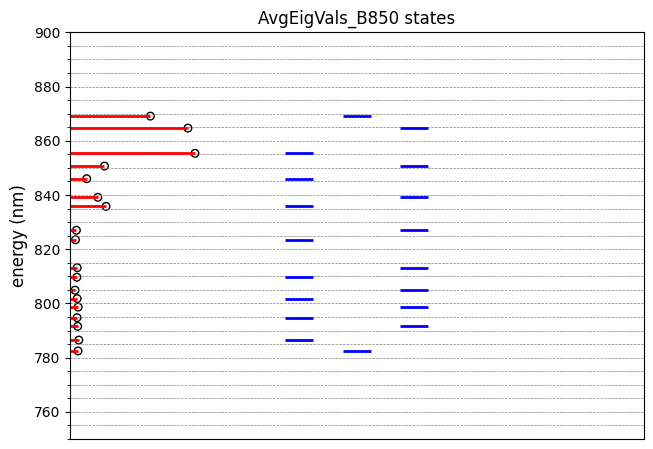

Figure(PyObject <Figure size 3840x2880 with 0 Axes>)

In [35]:

kVecs = [0,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,0];
avg_eig_valsp = wavenumber_to_nm.(avg_eig_vals)
plt.plot(kVecs,avg_eig_valsp,linestyle="none",marker = "_", markersize=20,markeredgewidth=2,color="blue") 
#PyPlot.display_figs()
plt.hlines(avg_eig_valsp,[-2]*num_sites,avg_absorption_strength_scaled ,color="red",lw=2) 
plt.scatter(avg_absorption_strength_scaled ,avg_eig_valsp,30,color="black",marker="o",edgecolor="black",facecolors="none")


# data = CSV.read("LH2_RPcells_HL_ABS.csv",CSV.Tables.matrix)
# wavelength = data[:,1]
# wavenumber = 1E7 *(1 ./(wavelength))
# OD = 15 .*data[:,2] .- 5.
# plot(OD,wavenumber,color="red",linestyle="-",linewidth=0.5) 



# data = CSV.read("LH2_RPcells_LL_ABS.csv",CSV.Tables.matrix)
# wavelength = data[:,1]
# wavenumber = 1E7 *(1 ./(wavelength))
# OD = 3.5 *data[:,2] .- 5
# plot(OD,wavelength,color="blue",linestyle="-",linewidth=0.5) 

tight_layout()
# plot formatting , straight up copy pasted
title("AvgEigVals_B850 states",fontsize=12)
ylim(750,900)
xlim(-5,5)
xticks([])
xlabel("",fontsize=12)
ylabel("energy (nm)",fontsize=12)
minorticks_on()
grid(which="minor",color="gray", linestyle="--", linewidth=0.5)
grid(which="major",color="gray", linestyle="--", linewidth=0.5)
PyPlot.display_figs()
figure(dpi = 600)
#figure(figsize = [8.5,5])

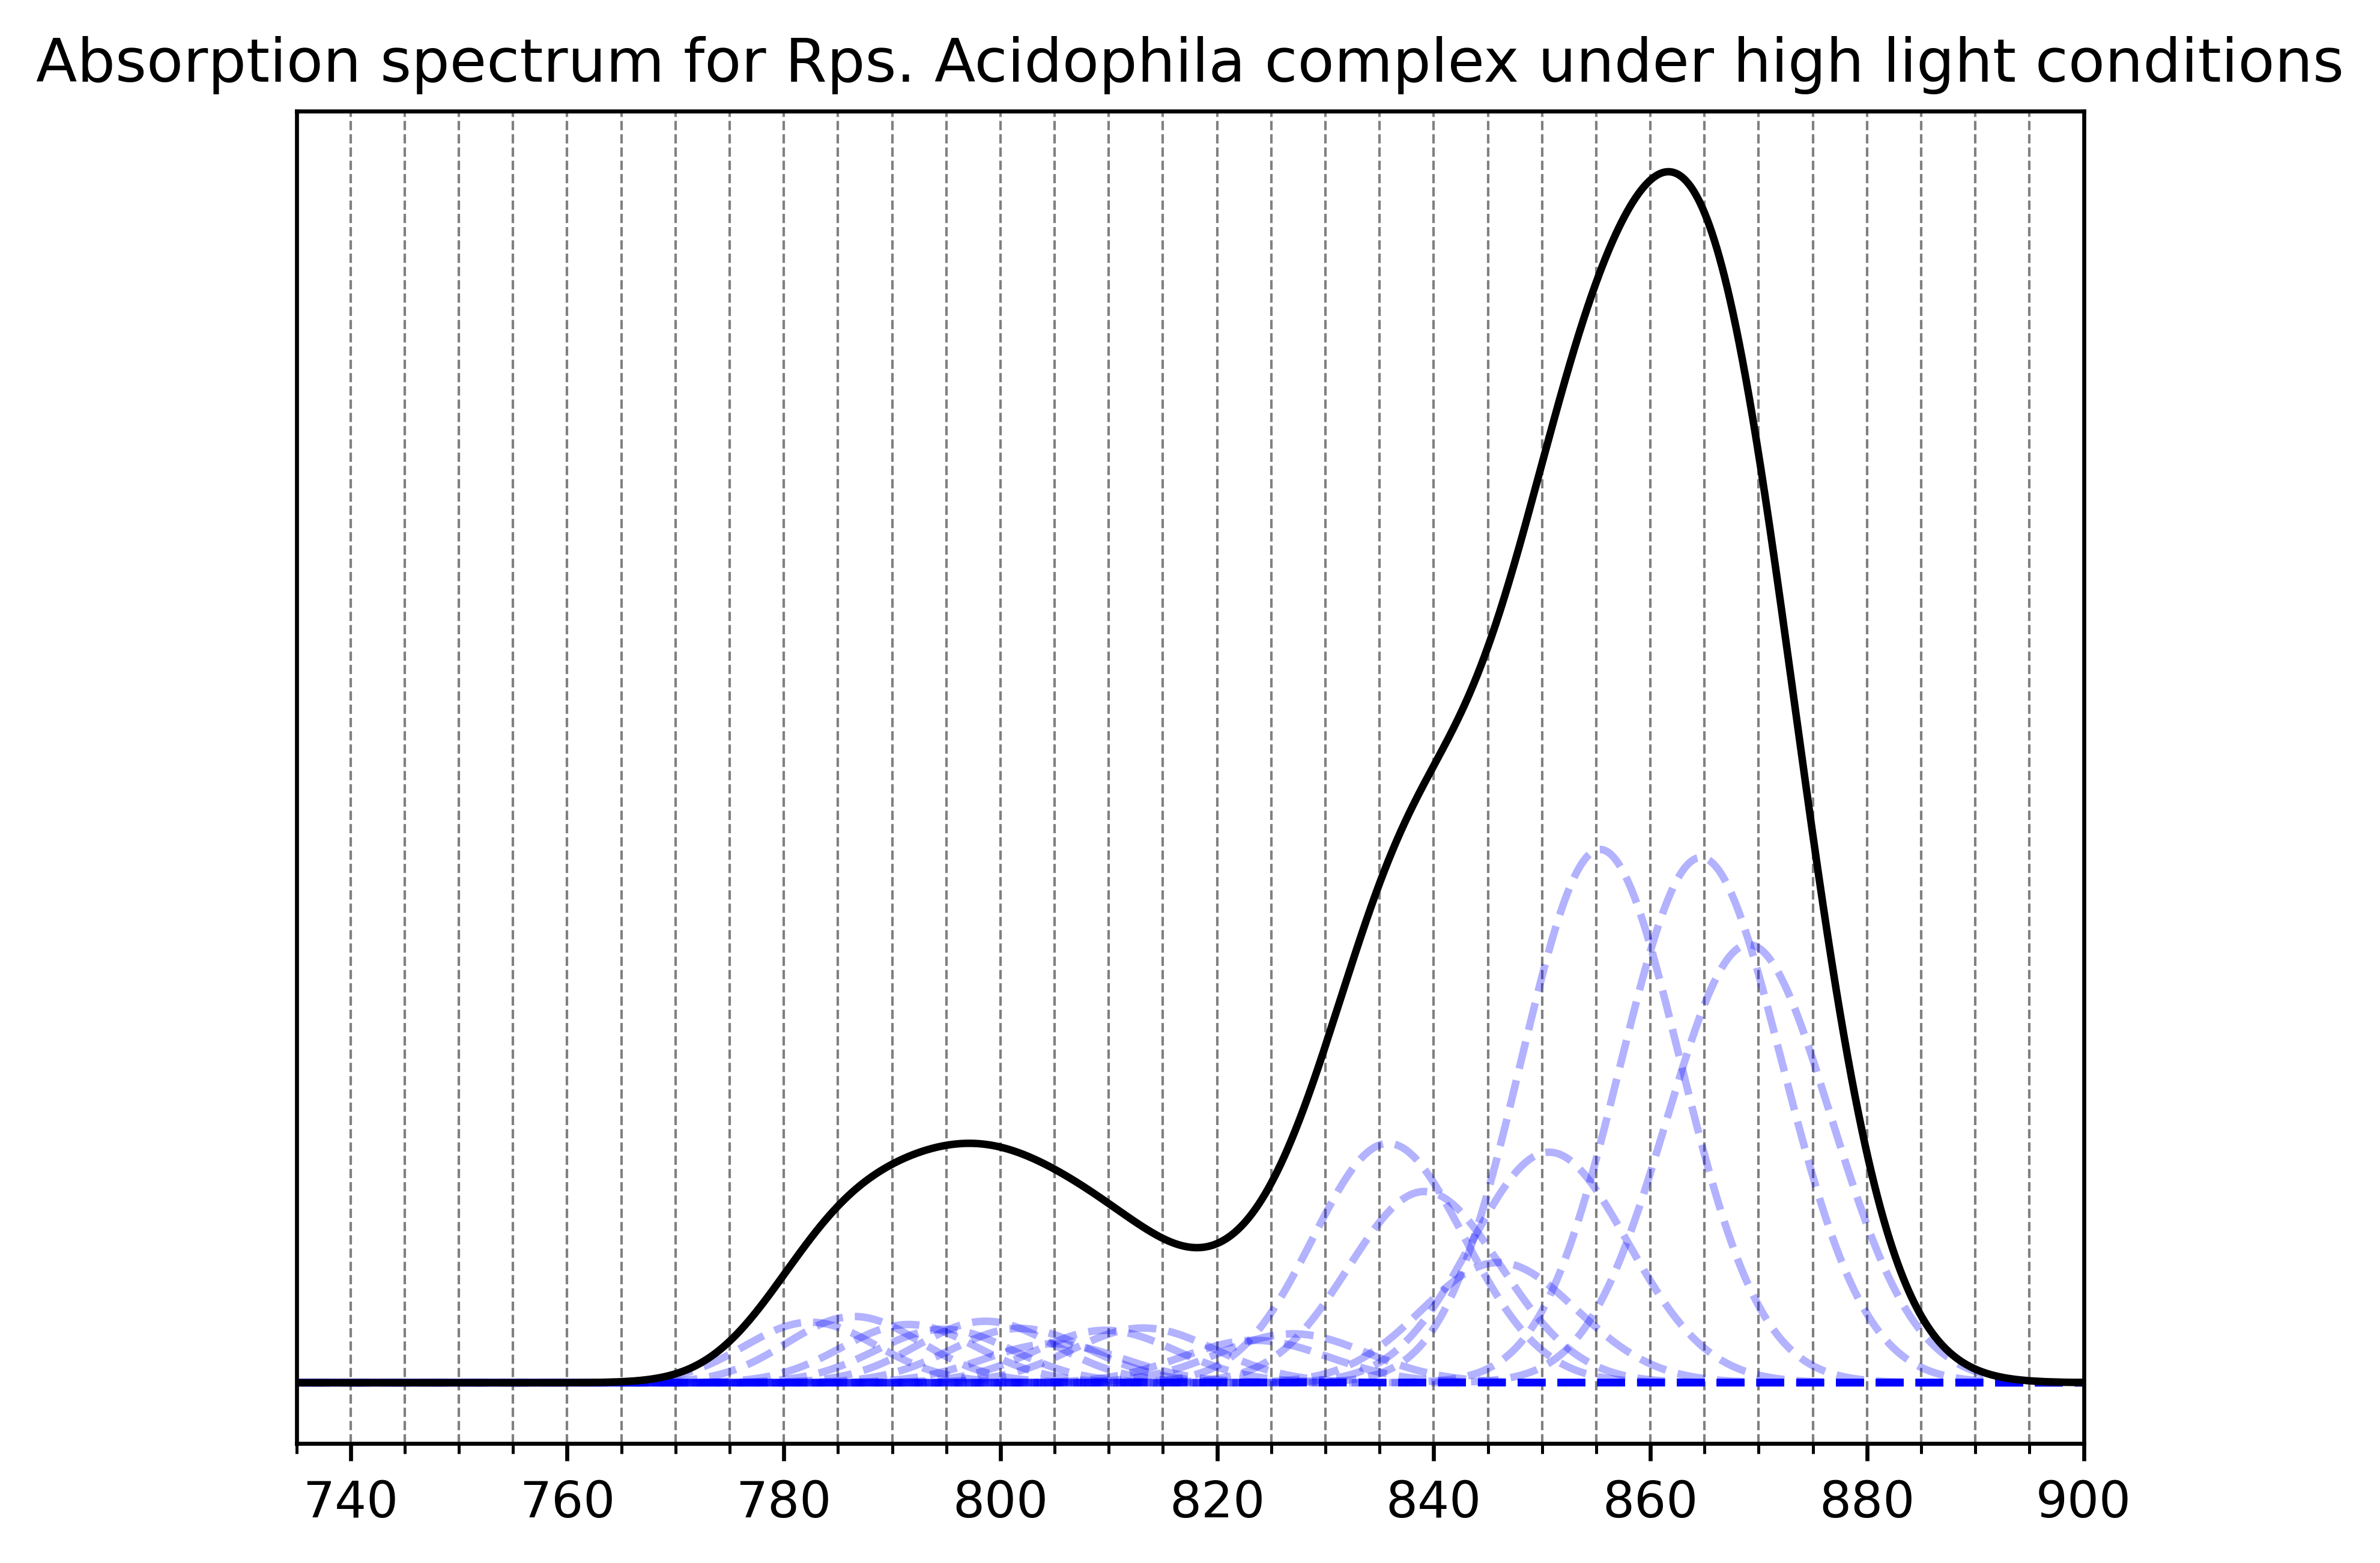

In [36]:
f(x,mu,sig) = 1/(sig*sqrt(pi))*exp(-(x-mu)^2/(2*sig^2)) # equation for a gaussian
main_list_1 = []
for k = 1:length(avg_eig_vals)
    list_1 = []
    for x = range(11000,14000,step = 1e-2)
        push!(list_1,f.(x,avg_eig_vals[k],100)*avg_absorption_strength_scaled[k])
    end    
    push!(main_list_1,list_1)
end

x = range(11000,14000,step = 1e-2)
x = wavenumber_to_nm.(x)
for i = 1:num_sites
    plot(x,abs.((main_list_1[i]).*(avg_absorption_strength_scaled[i]+5)) ,color = "blue",linestyle = "--",alpha = 0.3)
end
yticks([ ])
plot(x,abs.(sum(main_list_1 .* (avg_absorption_strength_scaled .+ 5))),color = "black")
xlim([ 735,900])


#######################################################################################


title("Absorption spectrum for Rps. Acidophila complex under high light conditions")
minorticks_on()
grid(which="minor",color="gray", linestyle="--", linewidth=0.5)
grid(which="major",color="gray", linestyle="--", linewidth=0.5)
PyPlot.display_figs()
xlabel("Energy")


;